In [1]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report,roc_curve, auc, plot_roc_curve, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit, StratifiedKFold, cross_val_score
from sklearn.utils import resample
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE 
from collections import Counter

pred_path = "../files/SeizurePrediction/"
dect_path = "../files/SeizureDetection/"

## generate file

## functions 

In [2]:
def balance_data(data_x, data_y,verbose=False):
    if verbose: print('Original dataset shape %s' % Counter(data_y))
    sm = SMOTE()
    X_res, y_res = sm.fit_resample(data_x, data_y)
    if verbose: print('Resampled dataset shape %s' % Counter(y_res))
    return X_res, y_res

def scale_data(x):
    train_scaler = preprocessing.StandardScaler().fit(x)
    return train_scaler.transform(x)

def print_statistics(y_test, y_pred,i=None):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    accuracy = (tp+tn)/(tp+fn+fp+tn)
    PPV = tp / (tp+fp)
    f1 =  2*((PPV*sensitivity)/(PPV+sensitivity))
    print("{:^5d},{:^15.4f},{:^15.4f},{:^15.4f},{:^15.4f},{:^15.4f}".format(i,specificity,sensitivity,accuracy,PPV,f1))

def train_pred(X, y, save=False, dop=""):
    cv = StratifiedKFold(5,shuffle = True, random_state=2021534)
    tprs = []
    aucs = []
    
    originalclass = []
    predictedclass = []

    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(8,6))
    print("{:^5s},{:^15s},{:^15s},{:^15s},{:^15s},{:^15s}".format("fold","specificity","sensitivity",'accuracy','PPV','f1'))
    for i, (train, test) in enumerate(cv.split(X, y)):
        X_train, y_train = balance_data(X[train], y[train])
        scaler = preprocessing.StandardScaler().fit(X[train])
        X_train = scaler.transform(X_train)
        X_test, y_test = X[test], y[test]
        X_test = scaler.transform(X_test)
        class_model = SVC(probability=True).fit(X_train, y_train)
#         y_pred = class_model.predict(X_test)
                
        y_hat = class_model.predict_proba(X_test)[:, 1]
        # Calculate the ROC Curves
        fpr, tpr, thresholds = roc_curve(y_test, y_hat)
        gmeans = np.sqrt(tpr * (1-fpr))
        
        ix = np.argmax(gmeans)
        y_pred = class_model.predict_proba(X_test)[:,1] >= thresholds[ix]
        ax.scatter(fpr[ix], tpr[ix], marker='o', color='red', alpha=0.3)
        originalclass.extend(y_test)
        predictedclass.extend(y_pred)
        
        viz = plot_roc_curve(class_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
        # basic statistics
        print_statistics(y_test, y_pred,i)
        print_statistics(y_test, class_model.predict(X_test),i)
        
    print(classification_report(originalclass, predictedclass))
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    ax.legend(loc="lower right")
    if save:
        plt.savefig(os.path.join("./figures", "svm_rocaoc_{}_{}.pdf".format(dop,save)))
    plt.show()
    return aucs


## main

========== Dog_1_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    0.9861     ,    0.9958     ,    1.0000     ,    0.9930     
  0  ,    1.0000     ,    0.9722     ,    0.9916     ,    1.0000     ,    0.9859     
  1  ,    0.9940     ,    1.0000     ,    0.9958     ,    0.9861     ,    0.9930     
  1  ,    1.0000     ,    0.9859     ,    0.9958     ,    1.0000     ,    0.9929     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    0.9718     ,    0.9916     ,    1.0000     ,    0.9857     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    0.9859     ,    0.9958     ,    1.0000     ,    0.9929     
  4  ,    0.9760     ,    1.0000     ,    0.9832     ,    0.9467     ,    0.9726     
  4  ,    0.9760     ,    0.9718     ,    0.9748     ,    0.9452     ,    0.9583     
              prec

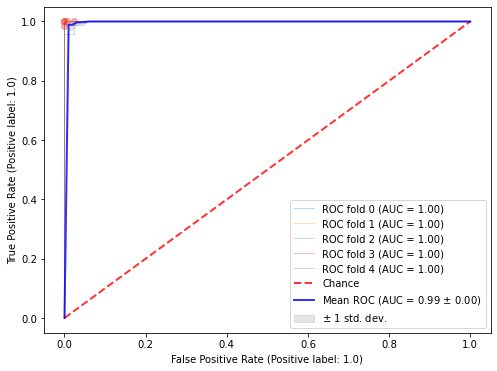

[0.9992930805056554, 0.9999580818242789, 1.0, 1.0, 0.9989879396137303]
0.999647820388733
========== Dog_2_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9891     ,    1.0000     ,    0.9905     ,    0.9324     ,    0.9650     
  0  ,    0.9956     ,    0.9420     ,    0.9886     ,    0.9701     ,    0.9559     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    0.9956     ,    1.0000     ,    0.9962     ,    0.9718     ,    0.9857     
  2  ,    0.9978     ,    1.0000     ,    0.9981     ,    0.9857     ,    0.9928     
  2  ,    1.0000     ,    0.9710     ,    0.9962     ,    1.0000     ,    0.9853     
  3  ,    0.9978     ,    1.0000     ,    0.9981     ,    0.9857     ,    0.9928     
  3  ,    0.9956     ,    1.0000     ,    0.9962     ,    0.9718     ,    0.9857     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    0.997

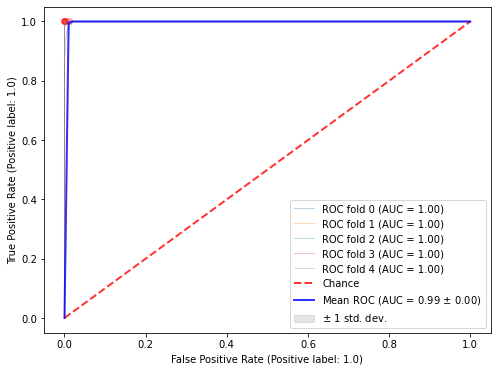

[0.9994316567206593, 1.0, 0.9999684253733699, 0.999984212686685, 1.0]
0.9998768589561429
========== Dog_3_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9963     ,    0.9948     ,    0.9962     ,    0.9646     ,    0.9795     
  0  ,    0.9974     ,    0.9896     ,    0.9967     ,    0.9744     ,    0.9819     
  1  ,    0.9905     ,    1.0000     ,    0.9914     ,    0.9143     ,    0.9552     
  1  ,    0.9968     ,    0.9792     ,    0.9952     ,    0.9691     ,    0.9741     
  2  ,    0.9926     ,    0.9948     ,    0.9928     ,    0.9317     ,    0.9622     
  2  ,    0.9947     ,    0.9896     ,    0.9943     ,    0.9500     ,    0.9694     
  3  ,    0.9974     ,    0.9948     ,    0.9971     ,    0.9745     ,    0.9845     
  3  ,    0.9974     ,    0.9948     ,    0.9971     ,    0.9745     ,    0.9845     
  4  ,    0.9890     ,    0.9844     ,    0.9885     ,    0.9000     ,    0.9403     
  4  ,    0.996

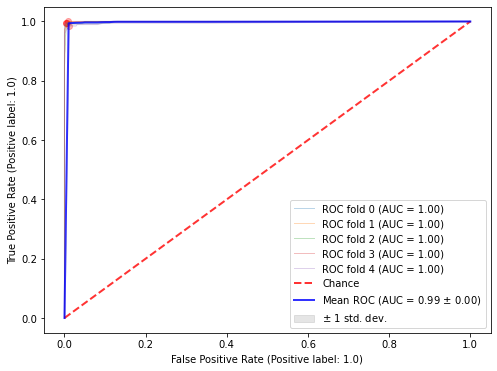

[0.9993612679446778, 0.9997647496498601, 0.9994597448354342, 0.9999152004551821, 0.9957176229866946]
0.9988437171743698
========== Dog_4_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    0.9991     ,    1.0000     ,    0.9992     ,    0.9904     ,    0.9952     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    0.9991     ,    1.0000     ,    0.9992     ,    0.9904     ,    0.9952     
  3  ,    0.9884     ,    1.0000     ,    0.9893     ,    0.8879     ,    0.9406     
  3  ,    0.9964     ,    0.9903     ,    0.9959     ,    0.9623     ,    0.9761     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,

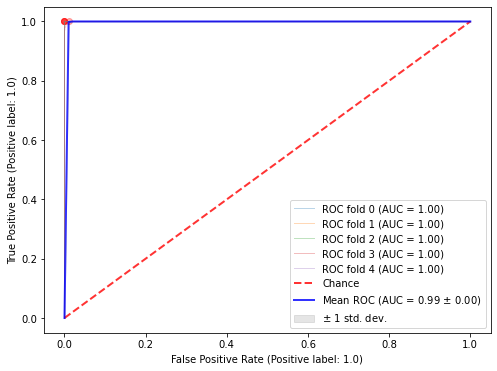

[1.0, 1.0, 1.0, 0.9998477572467551, 1.0]
0.999969551449351
========== Patient_1_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    0.9825     ,    0.9952     ,    1.0000     ,    0.9912     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    1.0000     ,   

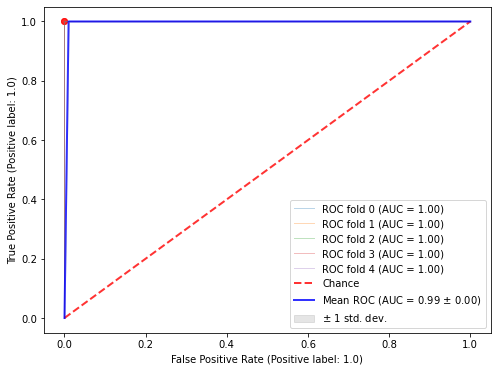

[1.0, 1.0, 1.0, 1.0, 1.0]
1.0
========== Patient_2_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9950     ,    0.9677     ,    0.9936     ,    0.9091     ,    0.9375     
  0  ,    0.9883     ,    0.9677     ,    0.9873     ,    0.8108     ,    0.8824     
  1  ,    0.9749     ,    1.0000     ,    0.9761     ,    0.6667     ,    0.8000     
  1  ,    0.9983     ,    0.8667     ,    0.9920     ,    0.9630     ,    0.9123     
  2  ,    0.9950     ,    1.0000     ,    0.9952     ,    0.9091     ,    0.9524     
  2  ,    0.9950     ,    1.0000     ,    0.9952     ,    0.9091     ,    0.9524     
  3  ,    0.9933     ,    1.0000     ,    0.9936     ,    0.8824     ,    0.9375     
  3  ,    0.9967     ,    0.9667     ,    0.9952     ,    0.9355     ,    0.9508     
  4  ,    0.9950     ,    0.9667     ,    0.9936     ,    0.9062     ,    0.9355     
  4  ,    0.9933     ,    0.9667     ,    0.9920     ,    0.8788     ,

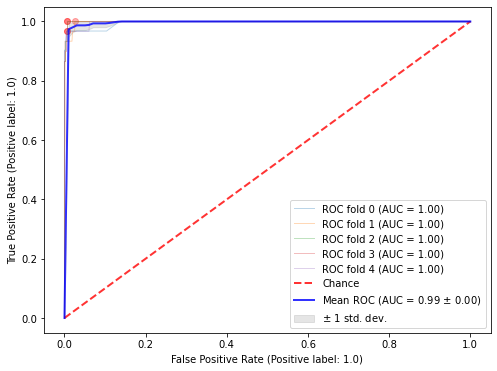

[0.9959003128708599, 0.9979375696767001, 0.9995540691192866, 0.9994983277591973, 0.9977703455964325]
0.9981321250044953
========== Patient_3_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9660     ,    0.9516     ,    0.9617     ,    0.9219     ,    0.9365     
  0  ,    0.9796     ,    0.8710     ,    0.9474     ,    0.9474     ,    0.9076     
  1  ,    0.9589     ,    0.9677     ,    0.9615     ,    0.9091     ,    0.9375     
  1  ,    0.9795     ,    0.9032     ,    0.9567     ,    0.9492     ,    0.9256     
  2  ,    0.9456     ,    0.9672     ,    0.9519     ,    0.8806     ,    0.9219     
  2  ,    0.9728     ,    0.8525     ,    0.9375     ,    0.9286     ,    0.8889     
  3  ,    0.9184     ,    1.0000     ,    0.9423     ,    0.8356     ,    0.9104     
  3  ,    0.9728     ,    0.8033     ,    0.9231     ,    0.9245     ,    0.8596     
  4  ,    0.9728     ,    0.9836     ,    0.9760     ,    0.9375  

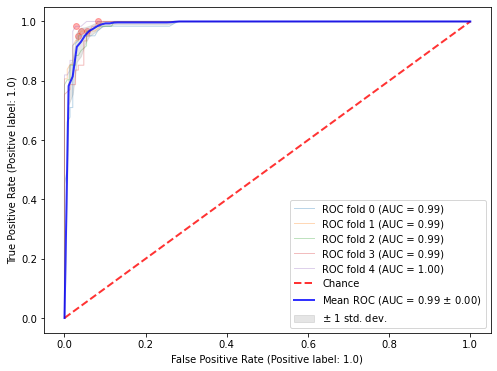

[0.9858459512837393, 0.9939239946973044, 0.991189918590387, 0.9896286383405821, 0.9962083193933311]
0.9913593644610689
========== Patient_4_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    0.7500     ,    0.9762     ,    1.0000     ,    0.8571     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    0.9737     ,    1.0000     ,    0.9762     ,    0.8000     ,    0.8889     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000   

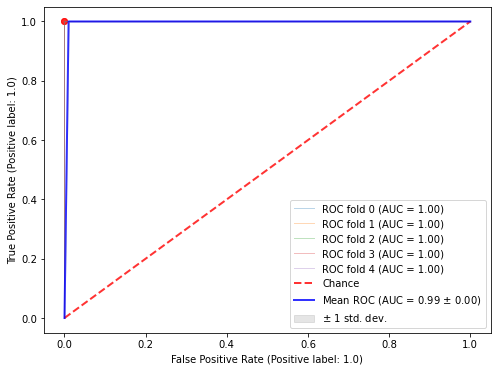

[1.0, 1.0, 1.0, 1.0, 1.0]
1.0
========== Patient_5_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9981     ,    0.9615     ,    0.9964     ,    0.9615     ,    0.9615     
  0  ,    1.0000     ,    0.8846     ,    0.9945     ,    1.0000     ,    0.9388     
  1  ,    0.9981     ,    1.0000     ,    0.9982     ,    0.9630     ,    0.9811     
  1  ,    0.9981     ,    0.8077     ,    0.9891     ,    0.9545     ,    0.8750     
  2  ,    0.9943     ,    1.0000     ,    0.9945     ,    0.8929     ,    0.9434     
  2  ,    0.9981     ,    0.9200     ,    0.9945     ,    0.9583     ,    0.9388     
  3  ,    0.9733     ,    0.9600     ,    0.9727     ,    0.6316     ,    0.7619     
  3  ,    1.0000     ,    0.8400     ,    0.9927     ,    1.0000     ,    0.9130     
  4  ,    0.9847     ,    1.0000     ,    0.9854     ,    0.7576     ,    0.8621     
  4  ,    1.0000     ,    0.8800     ,    0.9945     ,    1.0000     ,

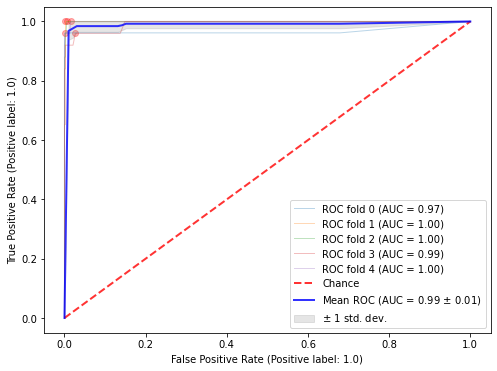

[0.967679070451537, 0.9993381379614649, 0.9996564885496183, 0.9931679389312977, 0.9994274809160306]
0.9918538233619897
========== Patient_6_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9964     ,    0.9778     ,    0.9950     ,    0.9565     ,    0.9670     
  0  ,    1.0000     ,    0.9556     ,    0.9967     ,    1.0000     ,    0.9773     
  1  ,    0.9892     ,    1.0000     ,    0.9900     ,    0.8824     ,    0.9375     
  1  ,    1.0000     ,    0.9778     ,    0.9983     ,    1.0000     ,    0.9888     
  2  ,    0.9982     ,    1.0000     ,    0.9983     ,    0.9783     ,    0.9890     
  2  ,    1.0000     ,    0.9556     ,    0.9967     ,    1.0000     ,    0.9773     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    0.9778     ,    0.9983     ,    1.0000     ,    0.9888     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000   

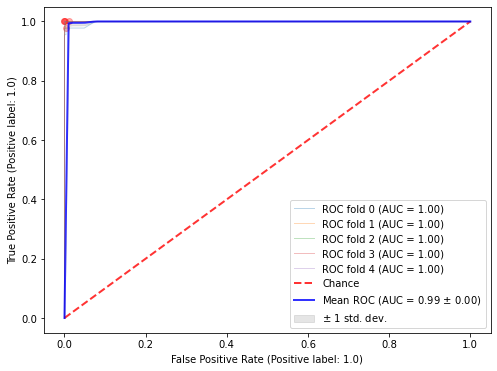

[0.9985385385385386, 0.9997797797797798, 0.9999598876855195, 1.0, 1.0]
0.9996556412007676
========== Patient_7_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9985     ,    1.0000     ,    0.9986     ,    0.9828     ,    0.9913     
  0  ,    1.0000     ,    0.9825     ,    0.9986     ,    1.0000     ,    0.9912     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    0.9985     ,    1.0000     ,    0.9986     ,    0.9825     ,    0.9912     
  2  ,    1.0000     ,    0.9821     ,    0.9986     ,    1.0000     ,    0.9910     
  3  ,    0.9954     ,    1.0000     ,    0.9957     ,    0.9492     ,    0.9739     
  3  ,    1.0000     ,    0.9821     ,    0.9986     ,    1.0000     ,    0.9910     
  4  ,    0.9985     ,    1.0000     ,    0.9986     ,    0.9825     ,    0.9912     
  4  ,    

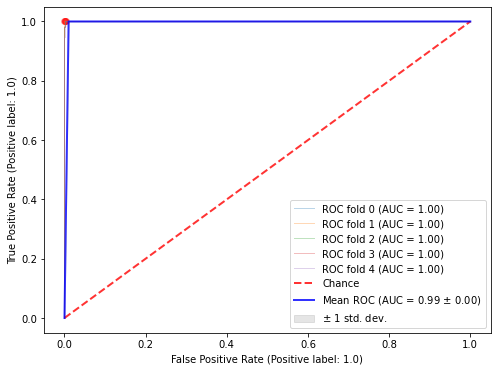

[0.9999729261425168, 1.0, 0.999972442680776, 0.99993110670194, 0.999917328042328]
0.9999587607135121
========== Patient_8_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9766     ,    1.0000     ,    0.9788     ,    0.8182     ,    0.9000     
  0  ,    0.9971     ,    0.9444     ,    0.9921     ,    0.9714     ,    0.9577     
  1  ,    0.9708     ,    1.0000     ,    0.9735     ,    0.7826     ,    0.8780     
  1  ,    0.9942     ,    0.9444     ,    0.9894     ,    0.9444     ,    0.9444     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    0.9971     ,    1.0000     ,    0.9974     ,    0.9730     ,    0.9863     
  3  ,    0.9971     ,    0.9722     ,    0.9947     ,    0.9722     ,    0.9722     
  3  ,    0.9854     ,    0.9722     ,    0.9841     ,    0.8750     ,    0.9211     
  4  ,    0.9971     ,    0.8611     ,    0.9841     ,    0.9688     ,    0.9118     

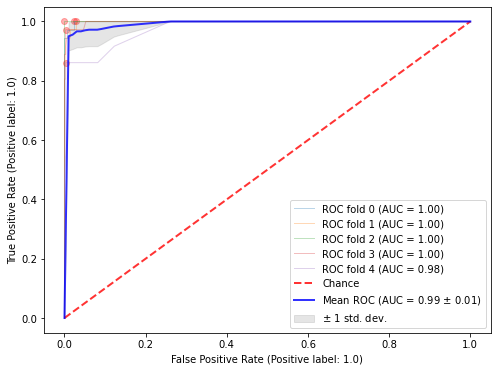

[0.9991877842755036, 0.9983349577647823, 1.0, 0.9983755685510072, 0.9773391812865496]
0.9946474983755687


In [4]:
file_list = [f for f in Path(dect_path).glob("*_reduced.csv")]
for f in file_list:
    data = pd.read_csv(f.resolve())
    sample = f.name.split('.')[0]
    print('='*10, sample ,'='*10)
    data_y = data["result"].to_numpy()
    data_x = data.loc[:, data.columns != 'result'].to_numpy()
    aucs = train_pred(data_x, data_y,save=sample)
    print(aucs)
    print(np.mean(aucs))

========== Dog_1_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.7402     ,    0.6538     ,    0.7361     ,    0.1133     ,    0.1932     
  0  ,    0.9746     ,    0.2308     ,    0.9387     ,    0.3158     ,    0.2667     
  1  ,    0.6289     ,    0.8077     ,    0.6375     ,    0.0995     ,    0.1772     
  1  ,    0.9590     ,    0.1538     ,    0.9201     ,    0.1600     ,    0.1569     
  2  ,    0.6250     ,    0.7692     ,    0.6320     ,    0.0943     ,    0.1681     
  2  ,    0.9453     ,    0.3077     ,    0.9145     ,    0.2222     ,    0.2581     
  3  ,    0.5801     ,    0.7600     ,    0.5885     ,    0.0812     ,    0.1467     
  3  ,    0.9629     ,    0.1200     ,    0.9236     ,    0.1364     ,    0.1277     
  4  ,    0.6484     ,    0.8400     ,    0.6574     ,    0.1045     ,    0.1858     
  4  ,    0.9590     ,    0.2800     ,    0.9274     ,    0.2500     ,    0.2642     
              prec

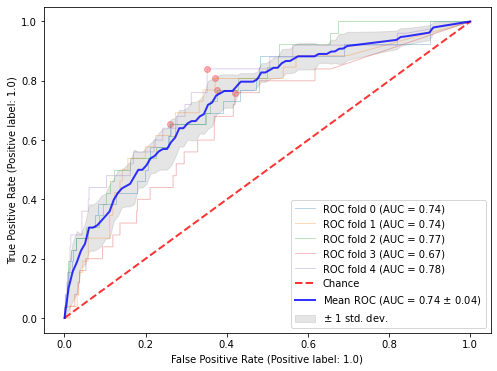

[0.7371544471153846, 0.7373422475961537, 0.7711087740384616, 0.67078125, 0.7773828125000001]
0.73875390625
========== Dog_2_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.8727     ,    0.8864     ,    0.8737     ,    0.3645     ,    0.5166     
  0  ,    0.9476     ,    0.7045     ,    0.9291     ,    0.5254     ,    0.6019     
  1  ,    0.8856     ,    0.8222     ,    0.8806     ,    0.3776     ,    0.5175     
  1  ,    0.9306     ,    0.6444     ,    0.9083     ,    0.4394     ,    0.5225     
  2  ,    0.8612     ,    0.8667     ,    0.8616     ,    0.3451     ,    0.4937     
  2  ,    0.9400     ,    0.6667     ,    0.9187     ,    0.4839     ,    0.5607     
  3  ,    0.8386     ,    0.9111     ,    0.8443     ,    0.3228     ,    0.4767     
  3  ,    0.9362     ,    0.6667     ,    0.9152     ,    0.4688     ,    0.5505     
  4  ,    0.8424     ,    0.9333     ,    0.8495     ,    0.3333     ,    0.4912   

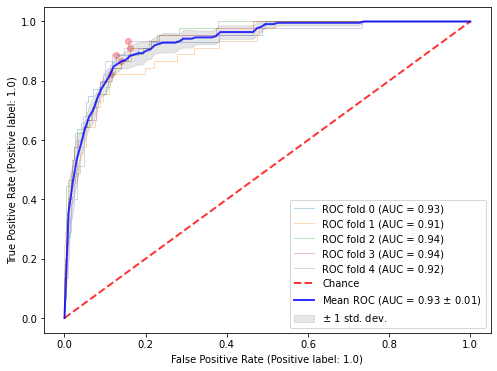

[0.9312223357167178, 0.9104023347925787, 0.9404210965186575, 0.937294142172191, 0.9249114029601835]
0.9288502624320657
========== Dog_3_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9206     ,    0.9091     ,    0.9200     ,    0.3646     ,    0.5204     
  0  ,    0.9850     ,    0.7792     ,    0.9752     ,    0.7229     ,    0.7500     
  1  ,    0.9681     ,    0.9091     ,    0.9653     ,    0.5882     ,    0.7143     
  1  ,    0.9896     ,    0.7922     ,    0.9802     ,    0.7922     ,    0.7922     
  2  ,    0.8887     ,    0.8831     ,    0.8884     ,    0.2845     ,    0.4304     
  2  ,    0.9889     ,    0.7143     ,    0.9758     ,    0.7639     ,    0.7383     
  3  ,    0.8249     ,    0.8961     ,    0.8283     ,    0.2041     ,    0.3325     
  3  ,    0.9896     ,    0.6234     ,    0.9721     ,    0.7500     ,    0.6809     
  4  ,    0.9238     ,    0.9342     ,    0.9243     ,    0.3777     , 

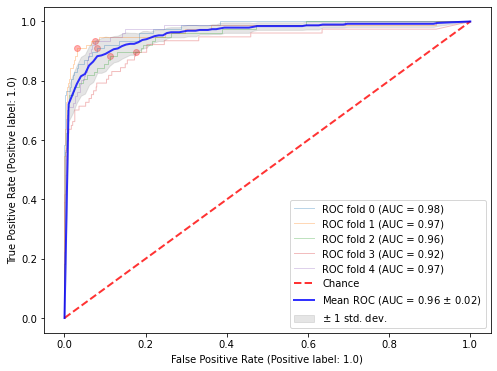

[0.9752857819264068, 0.9704663825757577, 0.9552725919913421, 0.9249526515151515, 0.9706859923245613]
0.959332680066644
========== Dog_4_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.8345     ,    0.9038     ,    0.8420     ,    0.3983     ,    0.5529     
  0  ,    0.8531     ,    0.8365     ,    0.8514     ,    0.4085     ,    0.5489     
  1  ,    0.8275     ,    0.8846     ,    0.8337     ,    0.3833     ,    0.5349     
  1  ,    0.8543     ,    0.8077     ,    0.8493     ,    0.4019     ,    0.5367     
  2  ,    0.8193     ,    0.8269     ,    0.8202     ,    0.3568     ,    0.4986     
  2  ,    0.8660     ,    0.7596     ,    0.8545     ,    0.4072     ,    0.5302     
  3  ,    0.8728     ,    0.7692     ,    0.8616     ,    0.4233     ,    0.5461     
  3  ,    0.8740     ,    0.7596     ,    0.8616     ,    0.4225     ,    0.5430     
  4  ,    0.7223     ,    0.9615     ,    0.7482     ,    0.2959     , 

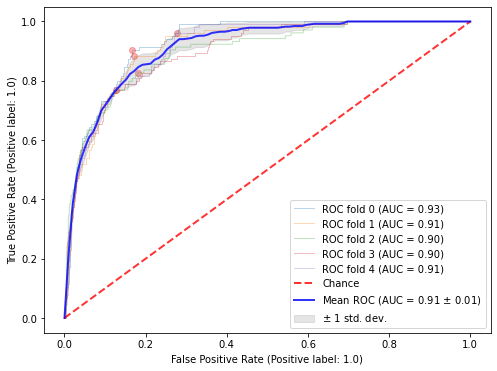

[0.9293975255513718, 0.9149408284023668, 0.8985453648915188, 0.9004353289650839, 0.9146620590611255]
0.9115962213742934
========== Dog_5_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9521     ,    0.9375     ,    0.9512     ,    0.5660     ,    0.7059     
  0  ,    0.9854     ,    0.6875     ,    0.9668     ,    0.7586     ,    0.7213     
  1  ,    0.9125     ,    0.9688     ,    0.9160     ,    0.4247     ,    0.5905     
  1  ,    0.9979     ,    0.7188     ,    0.9805     ,    0.9583     ,    0.8214     
  2  ,    0.9583     ,    0.9062     ,    0.9551     ,    0.5918     ,    0.7160     
  2  ,    0.9812     ,    0.7812     ,    0.9688     ,    0.7353     ,    0.7576     
  3  ,    0.9917     ,    1.0000     ,    0.9922     ,    0.8889     ,    0.9412     
  3  ,    0.9917     ,    1.0000     ,    0.9922     ,    0.8889     ,    0.9412     
  4  ,    0.9688     ,    1.0000     ,    0.9707     ,    0.6809     ,

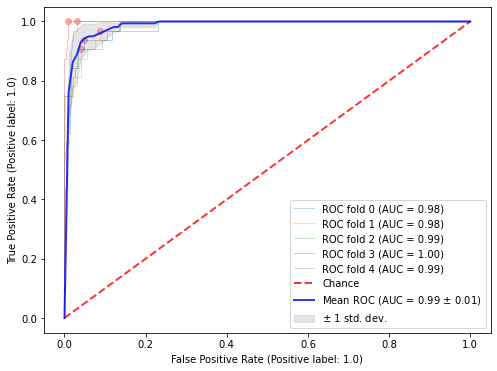

[0.9810546875, 0.9845052083333333, 0.98515625, 0.9991536458333333, 0.9942057291666667]
0.9888151041666667
========== Patient_1_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    0.9500     ,    0.9867     ,    1.0000     ,    0.9744     
  0  ,    0.7455     ,    1.0000     ,    0.8133     ,    0.5882     ,    0.7407     
  1  ,    0.9818     ,    1.0000     ,    0.9867     ,    0.9524     ,    0.9756     
  1  ,    0.8000     ,    1.0000     ,    0.8533     ,    0.6452     ,    0.7843     
  2  ,    0.9273     ,    0.9500     ,    0.9333     ,    0.8261     ,    0.8837     
  2  ,    0.7818     ,    0.9500     ,    0.8267     ,    0.6129     ,    0.7451     
  3  ,    0.9636     ,    0.9000     ,    0.9467     ,    0.9000     ,    0.9000     
  3  ,    0.7636     ,    0.9500     ,    0.8133     ,    0.5938     ,    0.7308     
  4  ,    0.9818     ,    0.8947     ,    0.9595     ,    0.9444     ,    0.9189

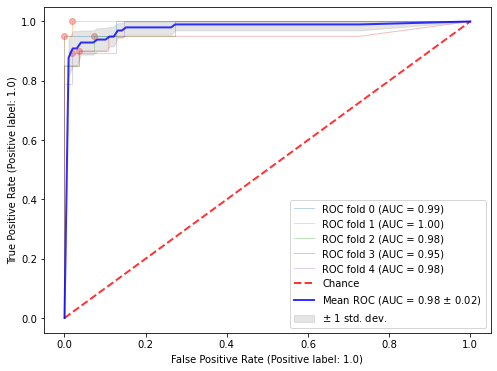

[0.9936363636363637, 0.999090909090909, 0.980909090909091, 0.9495454545454545, 0.9837320574162679]
0.9813827751196171
========== Patient_2_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9362     ,    0.8947     ,    0.9242     ,    0.8500     ,    0.8718     
  0  ,    0.9787     ,    0.7368     ,    0.9091     ,    0.9333     ,    0.8235     
  1  ,    0.9783     ,    0.9500     ,    0.9697     ,    0.9500     ,    0.9500     
  1  ,    1.0000     ,    0.9000     ,    0.9697     ,    1.0000     ,    0.9474     
  2  ,    0.9565     ,    1.0000     ,    0.9697     ,    0.9091     ,    0.9524     
  2  ,    1.0000     ,    0.9000     ,    0.9697     ,    1.0000     ,    0.9474     
  3  ,    1.0000     ,    0.9500     ,    0.9848     ,    1.0000     ,    0.9744     
  3  ,    1.0000     ,    0.9500     ,    0.9848     ,    1.0000     ,    0.9744     
  4  ,    0.9783     ,    0.9500     ,    0.9697     ,    0.9500    

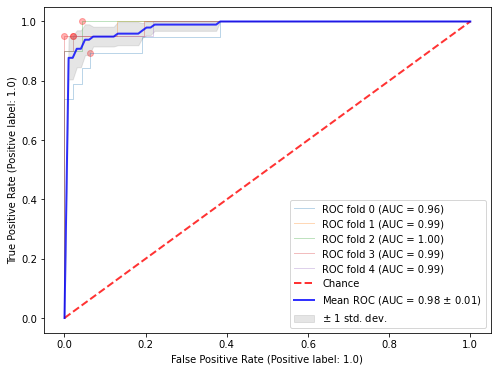

[0.9630459126539753, 0.9923913043478261, 0.9956521739130435, 0.9902173913043478, 0.9880434782608696]
0.9858700520960125


In [3]:
file_list = [f for f in Path(pred_path).glob("*_reduced.csv")]
for f in file_list:
    data = pd.read_csv(f.resolve())
    sample = f.name.split('.')[0]
    print('='*10, sample ,'='*10)
    data_y = data["result"].to_numpy()
    data_x = data.loc[:, data.columns != 'result'].to_numpy()
    aucs = train_pred(data_x, data_y,save=sample,dop="pred")
    print(aucs)
    print(np.mean(aucs))